Saving Net3_D0_F.inp to Net3_D0_F (1).inp
Loaded file: Net3_D0_F (1).inp


<ipython-input-2-3a28e0b2493f>:19: DeprecationWarning: wntr.network.WaterNetworkModel.get_graph is deprecated, use wntr.network.WaterNetworkModel.to_graph instead
  G = wn.get_graph()


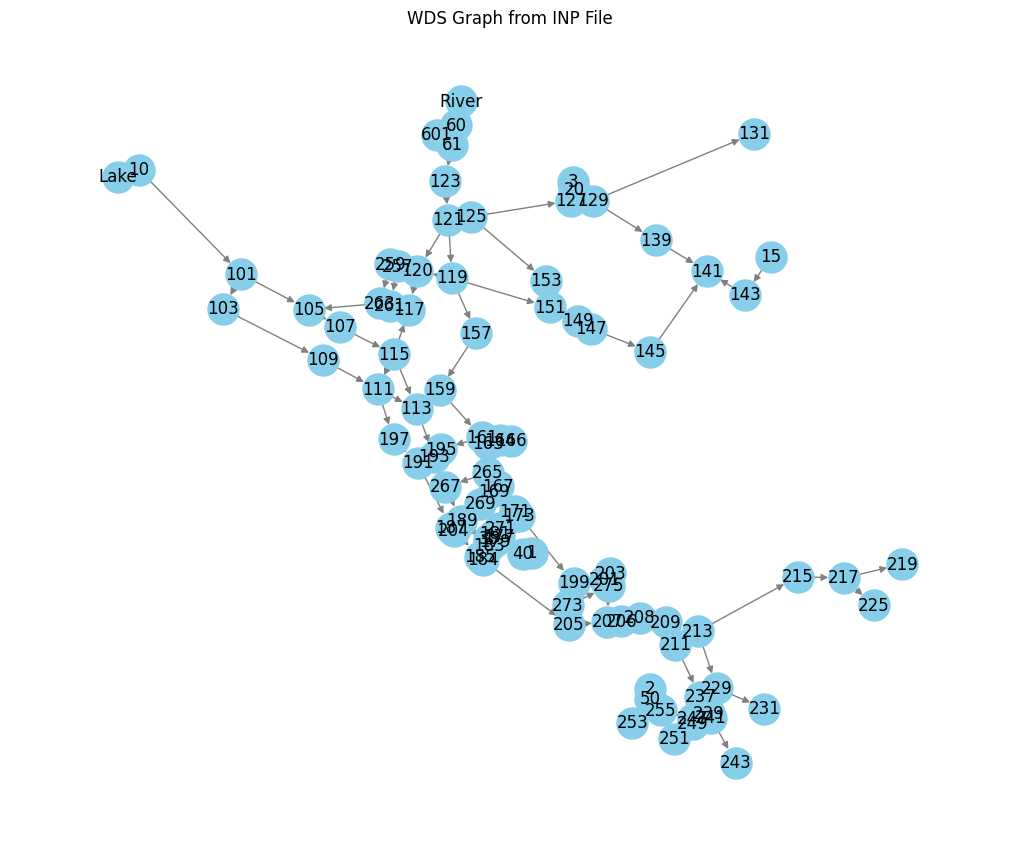

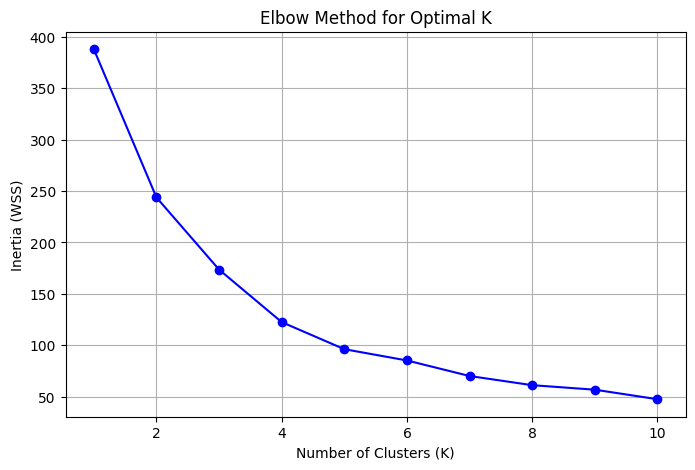

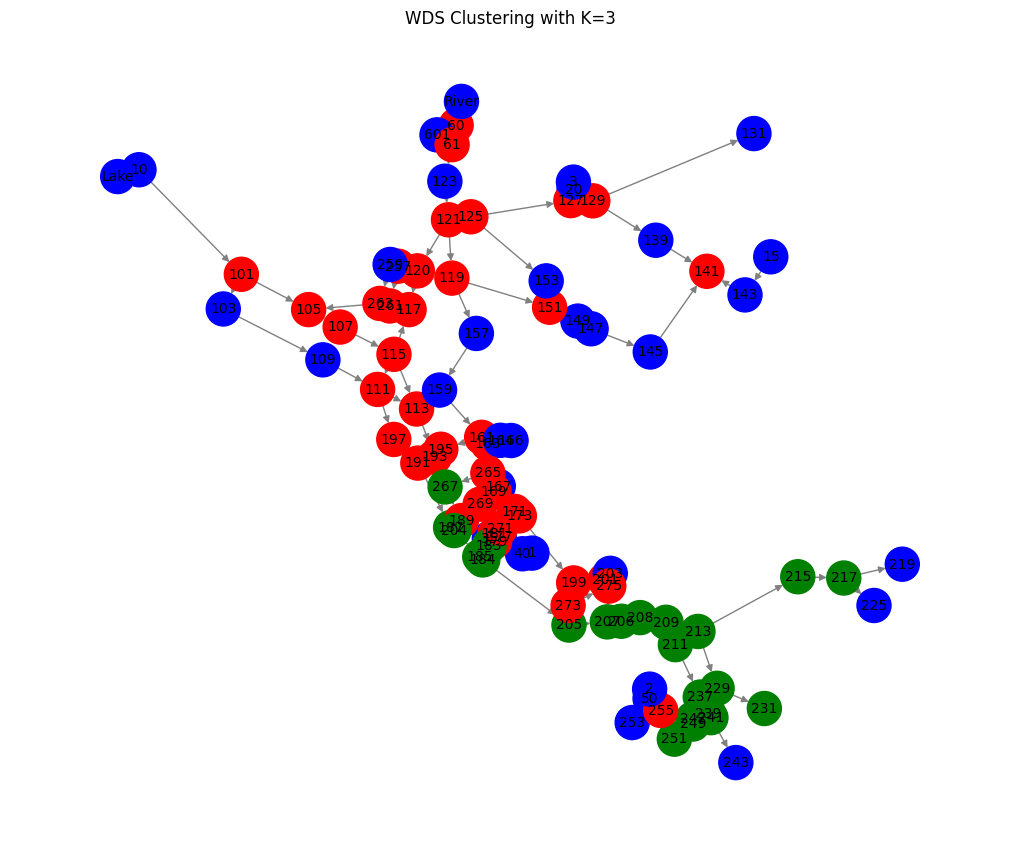

In [ ]:

from google.colab import files
uploaded = files.upload()
inp_file = list(uploaded.keys())[0]
print(f"Loaded file: {inp_file}")


import wntr
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


wn = wntr.network.WaterNetworkModel(inp_file)


G = wn.get_graph()

pos = {node: wn.get_node(node).coordinates for node in wn.node_name_list}


plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
plt.title("WDS Graph from INP File")
plt.axis("equal")
plt.show()



deg = nx.degree_centrality(G)
clo = nx.closeness_centrality(G)
bet = nx.betweenness_centrality(G)


G_digraph = nx.DiGraph(G)
eig = nx.eigenvector_centrality(G_digraph, max_iter=1000)


df = pd.DataFrame({
    'degree': deg,
    'closeness': clo,
    'betweenness': bet,
    'eigenvector': eig
})



scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)


inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)


plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WSS)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()


optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=0)
clusters = kmeans.fit_predict(X_scaled)
df['cluster'] = clusters


cluster_colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
node_colors = [cluster_colors[df.loc[node, 'cluster']] for node in G.nodes()]


plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=600, edge_color='gray', font_size=10)
plt.title(f"WDS Clustering with K={optimal_k}")
plt.axis("equal")
plt.show()


In [ ]:
!pip install wntr networkx matplotlib openpyxl scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 959.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 19.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


Saving Net3_D0_F.inp to Net3_D0_F (2).inp
📂 File uploaded: Net3_D0_F (2).inp


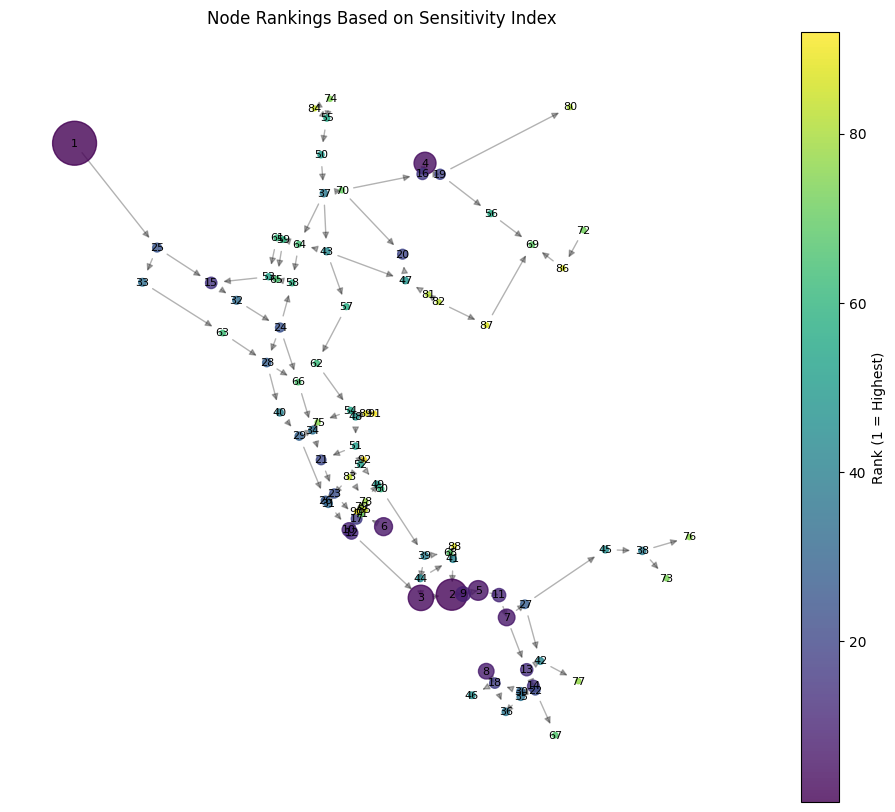


📤 Exported: WDS_Node_Sensitivity_Table.csv
📤 Exported: Metric_Entropy_Weights.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

import wntr
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from google.colab import files


uploaded = files.upload()
filename = list(uploaded.keys())[0]
print(f"📂 File uploaded: {filename}")


def load_network(inp_file):
    wn = wntr.network.WaterNetworkModel(inp_file)
    junctions = wn.junction_name_list

    elevations = {j: wn.get_node(j).elevation for j in junctions}
    demands = {j: wn.get_node(j).base_demand for j in junctions}
    coords = wn.query_node_attribute('coordinates')


    avg_elevation = np.mean(list(elevations.values()))
    elevation_diff = {j: elevations[j] - avg_elevation for j in junctions}


    total_demand = sum(demands.values())
    center_x = sum(coords[j][0] * demands[j] for j in junctions) / total_demand
    center_y = sum(coords[j][1] * demands[j] for j in junctions) / total_demand
    demand_center = np.array([center_x, center_y])
    distance_to_center = {j: np.linalg.norm(np.array(coords[j]) - demand_center) for j in junctions}


    G = wn.to_graph()
    adj_matrix = nx.adjacency_matrix(G).todense()


    deg_cent = nx.degree_centrality(G)
    bet_cent = nx.betweenness_centrality(G)
    close_cent = nx.closeness_centrality(G)


    data = pd.DataFrame({
        'NodeID': junctions,
        'Elevation': [elevations[j] for j in junctions],
        'ElevationDiff': [elevation_diff[j] for j in junctions],
        'DemandDistance': [distance_to_center[j] for j in junctions],
        'Degree': [deg_cent[j] for j in junctions],
        'Betweenness': [bet_cent[j] for j in junctions],
        'Closeness': [close_cent[j] for j in junctions],
    }).set_index('NodeID')

    return wn, G, data, coords


def normalize_metrics(data):
    scaler = MinMaxScaler()
    norm_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
    return norm_data


def compute_entropy_weights(norm_df):
    P = norm_df / norm_df.sum()
    P = P.replace(0, 1e-6)
    entropy = - (P * np.log(P)).sum() / np.log(len(norm_df))
    divergence = 1 - entropy
    weights = divergence / divergence.sum()
    return weights.to_frame(name='Weight')


def compute_sensitivity(norm_df, weights):
    scores = norm_df.mul(weights['Weight'].values, axis=1).sum(axis=1)
    ranked = scores.sort_values(ascending=False).reset_index()
    ranked.columns = ['NodeID', 'SensitivityIndex']
    ranked['Rank'] = ranked['SensitivityIndex'].rank(ascending=False).astype(int)
    return ranked.set_index('NodeID')


def visualize_network(G, coords, rankings):
    # Only include ranked nodes that are also in coords and in the graph
    valid_nodes = [node for node in rankings.index if node in coords and node in G.nodes()]
    pos = {node: coords[node] for node in valid_nodes}
    sizes = (1 / rankings.loc[valid_nodes]['Rank']).values * 1000
    cmap = plt.cm.viridis

    plt.figure(figsize=(12, 10))
    nx.draw_networkx_edges(G, pos, edgelist=[e for e in G.edges() if e[0] in pos and e[1] in pos], alpha=0.3)
    nodes = nx.draw_networkx_nodes(
        G, pos,
        nodelist=valid_nodes,
        node_color=rankings.loc[valid_nodes]['Rank'],
        node_size=sizes,
        cmap=cmap,
        alpha=0.8
    )
    nx.draw_networkx_labels(G, pos, labels=rankings.loc[valid_nodes]['Rank'].to_dict(), font_size=8)
    plt.title('Node Rankings Based on Sensitivity Index')
    plt.colorbar(nodes, label='Rank (1 = Highest)')
    plt.axis('off')
    plt.show()


def main(inp_file):
    wn, G, data, coords = load_network(inp_file)
    norm_df = normalize_metrics(data)
    weights = compute_entropy_weights(norm_df)
    ranked_df = compute_sensitivity(norm_df, weights)


    result_table = data.join(norm_df, rsuffix='_Normalized').join(ranked_df)


    visualize_network(G, coords, ranked_df)


    result_table.to_csv('WDS_Node_Sensitivity_Table.csv')
    weights.to_csv('Metric_Entropy_Weights.csv')
    print("\n📤 Exported: WDS_Node_Sensitivity_Table.csv")
    print("📤 Exported: Metric_Entropy_Weights.csv")


    files.download('WDS_Node_Sensitivity_Table.csv')
    files.download('Metric_Entropy_Weights.csv')

    return result_table, weights


result_table, metric_weights = main(filename)

Please upload your EPANET (.inp) file:


Saving Net3_D0_F.inp to Net3_D0_F (4).inp

📊 Entropy-Based Weights for Each Metric:
Demand                        0.3276
Eigenvector Centrality        0.2673
Betweenness Centrality        0.1825
Degree Centrality             0.0865
Closeness Centrality          0.0500
Proximity to Demand Center    0.0477
Shortest Path Length          0.0268
Elevation                     0.0116
dtype: float64
Results saved to global_entropy_weighted_graph_metrics.csv


<ipython-input-8-95a18dc2ae9d>:20: DeprecationWarning: wntr.network.WaterNetworkModel.get_graph is deprecated, use wntr.network.WaterNetworkModel.to_graph instead
  G = wn.get_graph()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

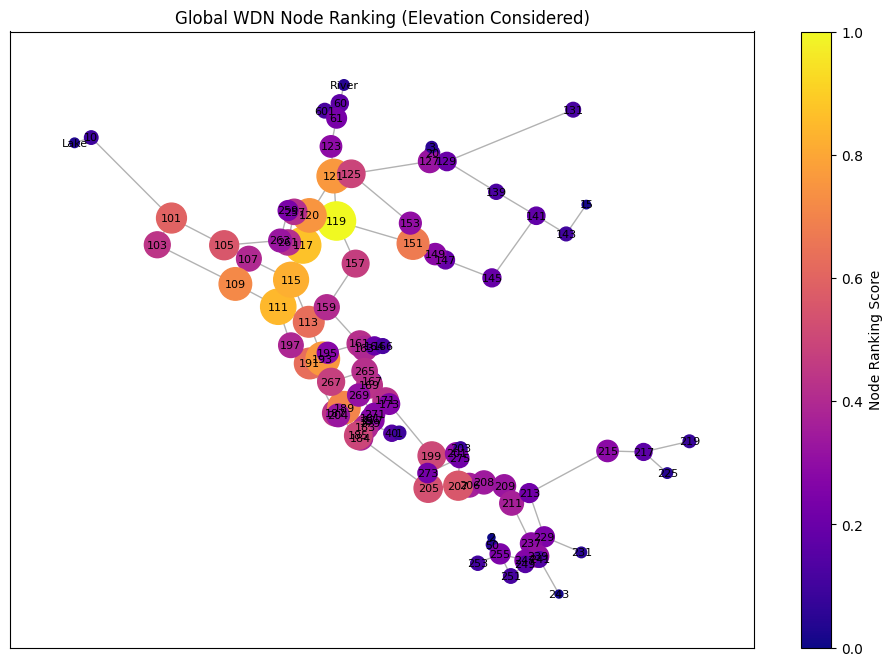

In [ ]:

!pip install wntr networkx pandas scikit-learn matplotlib


import wntr
import networkx as nx
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt


print("Please upload your EPANET (.inp) file:")
uploaded = files.upload()
inp_file_path = list(uploaded.keys())[0]


wn = wntr.network.WaterNetworkModel(inp_file_path)
G = wn.get_graph()
G = nx.Graph(G)


node_coordinates = {node_name: (node.coordinates[0], node.coordinates[1])
                    for node_name, node in wn.nodes() if node.coordinates}
elevation_data = {node_name: node.elevation for node_name, node in wn.junctions()}
demand_data = {node_name: node.base_demand for node_name, node in wn.junctions()}


elevation_data = {node: elevation_data.get(node, 0) for node in G.nodes()}
demand_data = {node: demand_data.get(node, 0) for node in G.nodes()}


degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
shortest_path_length = {
    node: sum(nx.shortest_path_length(G, source=node).values()) / (len(G.nodes()) - 1)
    for node in G.nodes()
}


total_demand = sum(demand_data.values())
x_center = sum(node_coordinates[node][0] * demand_data[node] for node in G.nodes()) / total_demand
y_center = sum(node_coordinates[node][1] * demand_data[node] for node in G.nodes()) / total_demand
proximity_to_demand_center = {
    node: np.sqrt((node_coordinates[node][0] - x_center) ** 2 + (node_coordinates[node][1] - y_center) ** 2)
    for node in G.nodes()
}


metrics_df = pd.DataFrame({
    "Node": list(G.nodes()),
    "Elevation": [elevation_data[node] for node in G.nodes()],
    "Demand": [demand_data[node] for node in G.nodes()],
    "Proximity to Demand Center": [proximity_to_demand_center[node] for node in G.nodes()],
    "Degree Centrality": [degree_centrality[node] for node in G.nodes()],
    "Closeness Centrality": [closeness_centrality[node] for node in G.nodes()],
    "Betweenness Centrality": [betweenness_centrality[node] for node in G.nodes()],
    "Eigenvector Centrality": [eigenvector_centrality[node] for node in G.nodes()],
    "Shortest Path Length": [shortest_path_length[node] for node in G.nodes()]
})


scaler = MinMaxScaler()
normalized_metrics = pd.DataFrame(
    scaler.fit_transform(metrics_df.iloc[:, 1:]),
    columns=metrics_df.columns[1:]
)
normalized_metrics["Node"] = metrics_df["Node"]


normalized_metrics["Shortest Path Length"] = 1 - normalized_metrics["Shortest Path Length"]
normalized_metrics["Proximity to Demand Center"] = 1 - normalized_metrics["Proximity to Demand Center"]


normalized_metrics["Elevation"] = 1 - normalized_metrics["Elevation"]


probabilities = normalized_metrics.iloc[:, :-1].div(
    normalized_metrics.iloc[:, :-1].sum(axis=0), axis=1
)


probabilities = probabilities.replace(0, 1e-12)


k = 1 / np.log(len(probabilities))
entropy = -k * (probabilities * np.log(probabilities)).sum(axis=0)


divergence = 1 - entropy
weights = divergence / divergence.sum()


print("\n📊 Entropy-Based Weights for Each Metric:")
print(weights.round(4).sort_values(ascending=False))


weighted_metrics = normalized_metrics.iloc[:, :-1].mul(weights, axis=1)


normalized_metrics["Score"] = weighted_metrics.sum(axis=1)


normalized_metrics["Rank"] = normalized_metrics["Score"].rank(ascending=False)


normalized_metrics.to_csv("global_entropy_weighted_graph_metrics.csv", index=False)
print("Results saved to global_entropy_weighted_graph_metrics.csv")


files.download("global_entropy_weighted_graph_metrics.csv")



fig, ax = plt.subplots(figsize=(12, 8))


node_colors = normalized_metrics["Score"].values
node_sizes = normalized_metrics["Score"].values * 1000


nx.draw_networkx_nodes(
    G, pos=node_coordinates,
    nodelist=normalized_metrics["Node"].values,
    node_size=node_sizes,
    cmap=plt.cm.plasma,
    node_color=node_colors,
    ax=ax
)
nx.draw_networkx_edges(G, pos=node_coordinates, alpha=0.3, ax=ax)
nx.draw_networkx_labels(G, pos=node_coordinates, font_size=8, ax=ax)


plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.plasma), label="Node Ranking Score", ax=ax)
plt.title("Global WDN Node Ranking (Elevation Considered)")
plt.show()


Please upload your EPANET (.inp) file:


Saving Net3_D0_F.inp to Net3_D0_F (6).inp


<ipython-input-10-4da2d6d77f6d>:20: DeprecationWarning: wntr.network.WaterNetworkModel.get_graph is deprecated, use wntr.network.WaterNetworkModel.to_graph instead
  G = wn.get_graph()



📊 Entropy-Based Weights for DMA: DMA1
Demand                        0.2403
Betweenness Centrality        0.2215
Elevation                     0.1455
Degree Centrality             0.1272
Eigenvector Centrality        0.1270
Proximity to Demand Center    0.0843
Closeness Centrality          0.0286
Shortest Path Length          0.0257
dtype: float64

📊 Entropy-Based Weights for DMA: DMA2
Demand                        0.3670
Elevation                     0.1685
Betweenness Centrality        0.1401
Degree Centrality             0.0924
Eigenvector Centrality        0.0734
Shortest Path Length          0.0600
Proximity to Demand Center    0.0502
Closeness Centrality          0.0484
dtype: float64

📊 Entropy-Based Weights for DMA: DMA3
Demand                        0.1917
Elevation                     0.1666
Betweenness Centrality        0.1629
Eigenvector Centrality        0.1562
Degree Centrality             0.1011
Closeness Centrality          0.0899
Shortest Path Length          0.0732
Pr

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

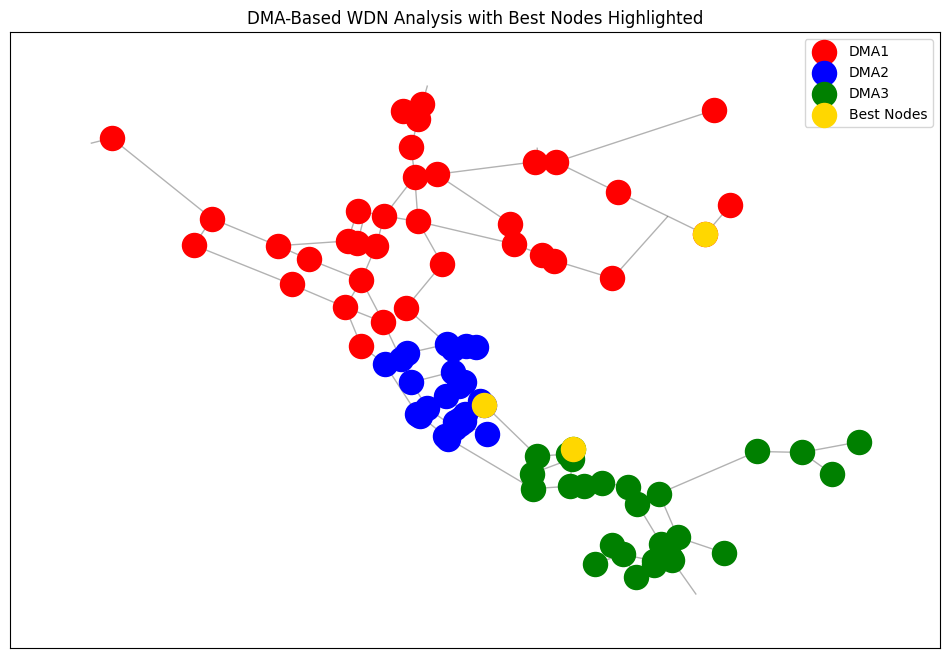

In [ ]:

!pip install wntr networkx pandas scikit-learn matplotlib


import wntr
import networkx as nx
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt


print("Please upload your EPANET (.inp) file:")
uploaded = files.upload()
inp_file_path = list(uploaded.keys())[0]


wn = wntr.network.WaterNetworkModel(inp_file_path)
G = wn.get_graph()
G = nx.Graph(G)


dma_nodes = {
    "DMA1": {10, 101, 197, 113, 159, 157, 119, 151, 149, 147, 145, 143, 15, 139, 129, 131,
             127, 125, 153, 121, 123, 61, 601, 60, 120, 259, 117, 261, 263, 105, 107, 115,
             111, 109, 103},  # Excluded 57 and 144
    "DMA2": {191, 193, 195, 161, 163, 164, 166, 265, 267, 169, 167, 269, 189, 187, 204,
             185, 183, 179, 35, 177, 181, 271, 171, 173, 184, 40},
    "DMA3": {199, 201, 203, 275, 273, 205, 207, 206, 208, 209, 211, 213, 215, 217, 219,
             225, 229, 231, 237, 239, 241, 249, 247, 255, 50, 253, 251, 273, 231}
}


dma_nodes = {k: {str(node) for node in v} for k, v in dma_nodes.items()}


node_coordinates = {node_name: (node.coordinates[0], node.coordinates[1])
                    for node_name, node in wn.nodes() if node.coordinates}
elevation_data = {node_name: node.elevation for node_name, node in wn.junctions()}
demand_data = {node_name: node.base_demand for node_name, node in wn.junctions()}


elevation_data = {node: elevation_data.get(node, 0) for node in G.nodes()}
demand_data = {node: demand_data.get(node, 0) for node in G.nodes()}


final_results = []
best_nodes = {}


for dma, dma_nodes_list in dma_nodes.items():

    dma_nodes_filtered = [node for node in dma_nodes_list if node in G.nodes()]


    if not dma_nodes_filtered:
        print(f"Warning: DMA {dma} has no nodes in the graph. Skipping...")
        continue

    subgraph = G.subgraph(dma_nodes_filtered)


    degree_centrality = nx.degree_centrality(subgraph)
    closeness_centrality = nx.closeness_centrality(subgraph)
    betweenness_centrality = nx.betweenness_centrality(subgraph)
    eigenvector_centrality = nx.eigenvector_centrality(subgraph, max_iter=1000)
    shortest_path_length = {
        node: sum(nx.shortest_path_length(subgraph, source=node).values()) / (len(subgraph.nodes()) - 1)
        for node in subgraph.nodes()
    }


    total_demand = sum(demand_data[node] for node in dma_nodes_filtered)
    x_center = sum(node_coordinates[node][0] * demand_data[node] for node in dma_nodes_filtered) / total_demand
    y_center = sum(node_coordinates[node][1] * demand_data[node] for node in dma_nodes_filtered) / total_demand
    proximity_to_demand_center = {
        node: np.sqrt((node_coordinates[node][0] - x_center) ** 2 + (node_coordinates[node][1] - y_center) ** 2)
        for node in dma_nodes_filtered
    }


    metrics_df = pd.DataFrame({
        "Node": dma_nodes_filtered,
        "Elevation": [elevation_data[node] for node in dma_nodes_filtered],
        "Demand": [demand_data[node] for node in dma_nodes_filtered],
        "Proximity to Demand Center": [proximity_to_demand_center[node] for node in dma_nodes_filtered],
        "Degree Centrality": [degree_centrality[node] for node in dma_nodes_filtered],
        "Closeness Centrality": [closeness_centrality[node] for node in dma_nodes_filtered],
        "Betweenness Centrality": [betweenness_centrality[node] for node in dma_nodes_filtered],
        "Eigenvector Centrality": [eigenvector_centrality[node] for node in dma_nodes_filtered],
        "Shortest Path Length": [shortest_path_length[node] for node in dma_nodes_filtered]
    })


    scaler = MinMaxScaler()
    normalized_metrics = pd.DataFrame(
        scaler.fit_transform(metrics_df.iloc[:, 1:]), columns=metrics_df.columns[1:]
    )
    normalized_metrics["Node"] = metrics_df["Node"]


    probabilities = normalized_metrics.iloc[:, :-1].div(normalized_metrics.iloc[:, :-1].sum(axis=0), axis=1)
    probabilities = probabilities.replace(0, 1e-12)
    entropy = -1 / np.log(len(probabilities)) * (probabilities * np.log(probabilities)).sum(axis=0)
    weights = (1 - entropy) / (1 - entropy).sum()

    print(f"\n📊 Entropy-Based Weights for DMA: {dma}")
    print(weights.round(4).sort_values(ascending=False))



    weighted_metrics = normalized_metrics.iloc[:, :-1].mul(weights, axis=1)
    normalized_metrics["Score"] = weighted_metrics.sum(axis=1)
    normalized_metrics["Rank"] = normalized_metrics["Score"].rank(ascending=False)
    normalized_metrics["DMA"] = dma


    best_node = normalized_metrics.loc[normalized_metrics["Rank"].idxmax(), "Node"]
    best_nodes[dma] = best_node

    final_results.append(normalized_metrics)


final_output = pd.concat(final_results)


final_output.to_csv("dma_ranked_nodes.csv", index=False)
print("Results saved to dma_ranked_nodes.csv")


files.download("dma_ranked_nodes.csv")


plt.figure(figsize=(12, 8))
colors = ["red", "blue", "green"]
for i, (dma, dma_nodes_list) in enumerate(dma_nodes.items()):
    nx.draw_networkx_nodes(G, pos=node_coordinates, nodelist=list(dma_nodes_list),
                           node_color=colors[i], label=f"{dma}")


nx.draw_networkx_nodes(G, pos=node_coordinates, nodelist=list(best_nodes.values()),
                       node_color="gold", node_size=300, label="Best Nodes")

nx.draw_networkx_edges(G, pos=node_coordinates, alpha=0.3)
plt.legend()
plt.title("DMA-Based WDN Analysis with Best Nodes Highlighted")
plt.show()

Please upload your EPANET (.inp) file:


Saving Net3_D0_F.inp to Net3_D0_F (8).inp

📊 Entropy-Based Weights for Cluster 0:
Demand                        0.4339
Eigenvector Centrality        0.1585
Betweenness Centrality        0.1528
Degree Centrality             0.1105
Closeness Centrality          0.0550
Proximity to Demand Center    0.0431
Shortest Path Length          0.0289
Elevation                     0.0173
dtype: float64

📊 Entropy-Based Weights for Cluster 1:
Demand                        0.3887
Betweenness Centrality        0.1831
Eigenvector Centrality        0.1697
Degree Centrality             0.1004
Closeness Centrality          0.0654
Shortest Path Length          0.0394
Proximity to Demand Center    0.0355
Elevation                     0.0179
dtype: float64

📊 Entropy-Based Weights for Cluster 2:
Demand                        0.2269
Betweenness Centrality        0.2132
Degree Centrality             0.1845
Eigenvector Centrality        0.1379
Closeness Centrality          0.1036
Shortest Path Length          0

<ipython-input-12-450f24abc965>:22: DeprecationWarning: wntr.network.WaterNetworkModel.get_graph is deprecated, use wntr.network.WaterNetworkModel.to_graph instead
  G = wn.get_graph()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

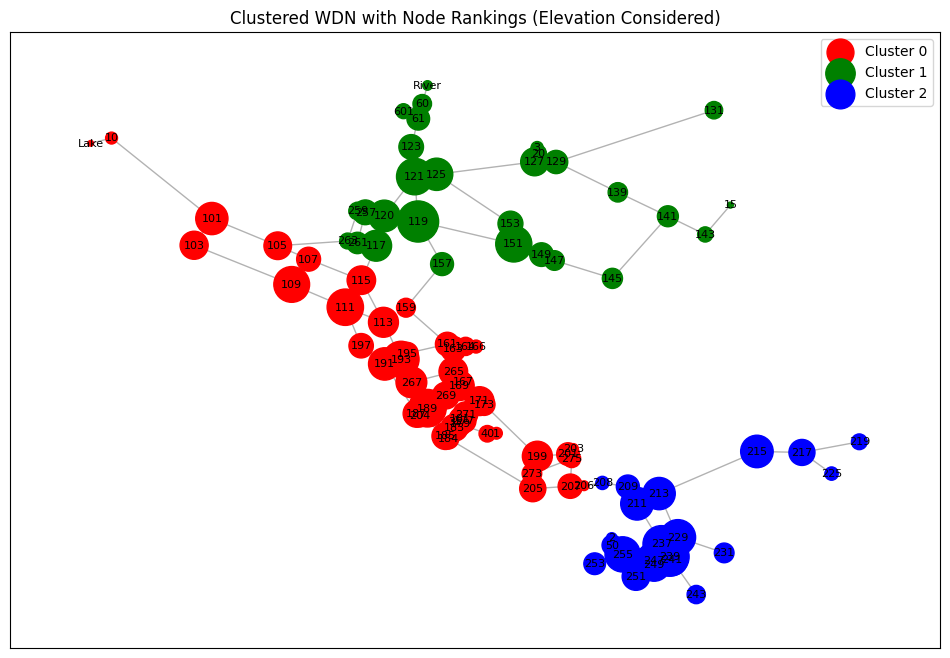

In [ ]:

!pip install wntr networkx pandas scikit-learn matplotlib


import wntr
import networkx as nx
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import SpectralClustering
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


print("Please upload your EPANET (.inp) file:")
uploaded = files.upload()
inp_file_path = list(uploaded.keys())[0]


wn = wntr.network.WaterNetworkModel(inp_file_path)
G = wn.get_graph()
G = nx.Graph(G)


node_coordinates = {node_name: (node.coordinates[0], node.coordinates[1])
                    for node_name, node in wn.nodes() if node.coordinates}
elevation_data = {node_name: node.elevation for node_name, node in wn.junctions()}
demand_data = {node_name: node.base_demand for node_name, node in wn.junctions()}


elevation_data = {node: elevation_data.get(node, 0) for node in G.nodes()}
demand_data = {node: demand_data.get(node, 0) for node in G.nodes()}


adj_matrix = nx.adjacency_matrix(G, weight='weight').todense()


n_clusters = 3
clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
cluster_labels = clustering.fit_predict(adj_matrix)


for node, cluster in zip(G.nodes(), cluster_labels):
    G.nodes[node]['cluster'] = cluster


final_results = []


for cluster_id in range(n_clusters):
    cluster_nodes = [node for node in G.nodes() if G.nodes[node]['cluster'] == cluster_id]
    subgraph = G.subgraph(cluster_nodes)


    degree_centrality = nx.degree_centrality(subgraph)
    closeness_centrality = nx.closeness_centrality(subgraph)
    betweenness_centrality = nx.betweenness_centrality(subgraph)
    eigenvector_centrality = nx.eigenvector_centrality(subgraph, max_iter=1000)
    shortest_path_length = {
        node: sum(nx.shortest_path_length(subgraph, source=node).values()) / (len(subgraph.nodes()) - 1)
        for node in subgraph.nodes()
    }


    total_demand = sum(demand_data[node] for node in cluster_nodes)
    x_center = sum(node_coordinates[node][0] * demand_data[node] for node in cluster_nodes) / total_demand
    y_center = sum(node_coordinates[node][1] * demand_data[node] for node in cluster_nodes) / total_demand
    proximity_to_demand_center = {
        node: np.sqrt((node_coordinates[node][0] - x_center) ** 2 + (node_coordinates[node][1] - y_center) ** 2)
        for node in cluster_nodes
    }


    metrics_df = pd.DataFrame({
        "Node": cluster_nodes,
        "Elevation": [elevation_data[node] for node in cluster_nodes],
        "Demand": [demand_data[node] for node in cluster_nodes],
        "Proximity to Demand Center": [proximity_to_demand_center[node] for node in cluster_nodes],
        "Degree Centrality": [degree_centrality[node] for node in cluster_nodes],
        "Closeness Centrality": [closeness_centrality[node] for node in cluster_nodes],
        "Betweenness Centrality": [betweenness_centrality[node] for node in cluster_nodes],
        "Eigenvector Centrality": [eigenvector_centrality[node] for node in cluster_nodes],
        "Shortest Path Length": [shortest_path_length[node] for node in cluster_nodes]
    })


    scaler = MinMaxScaler()
    normalized_metrics = pd.DataFrame(
        scaler.fit_transform(metrics_df.iloc[:, 1:]),
        columns=metrics_df.columns[1:]
    )
    normalized_metrics["Node"] = metrics_df["Node"]


    normalized_metrics["Shortest Path Length"] = 1 - normalized_metrics["Shortest Path Length"]
    normalized_metrics["Proximity to Demand Center"] = 1 - normalized_metrics["Proximity to Demand Center"]


    normalized_metrics["Elevation"] = 1 - normalized_metrics["Elevation"]


    probabilities = normalized_metrics.iloc[:, :-1].div(
        normalized_metrics.iloc[:, :-1].sum(axis=0), axis=1
    )


    probabilities = probabilities.replace(0, 1e-12)


    k = 1 / np.log(len(probabilities))
    entropy = -k * (probabilities * np.log(probabilities)).sum(axis=0)


    divergence = 1 - entropy
    weights = divergence / divergence.sum()

    print(f"\n📊 Entropy-Based Weights for Cluster {cluster_id}:")
    print(weights.round(4).sort_values(ascending=False))



    weighted_metrics = normalized_metrics.iloc[:, :-1].mul(weights, axis=1)


    normalized_metrics["Score"] = weighted_metrics.sum(axis=1)


    normalized_metrics["Rank"] = normalized_metrics["Score"].rank(ascending=False)


    normalized_metrics["Cluster"] = cluster_id


    final_results.append(normalized_metrics)


final_output = pd.concat(final_results)


final_output.to_csv("clustered_entropy_weighted_graph_metrics.csv", index=False)
print("Results saved to clustered_entropy_weighted_graph_metrics.csv")


files.download("clustered_entropy_weighted_graph_metrics.csv")


plt.figure(figsize=(12, 8))


cluster_colors = ['red', 'green', 'blue']
cmap = ListedColormap(cluster_colors[:n_clusters])


for cluster_id in range(n_clusters):
    cluster_nodes = final_output[final_output["Cluster"] == cluster_id]
    nx.draw_networkx_nodes(
        G, pos=node_coordinates,
        nodelist=cluster_nodes["Node"].values,
        node_size=cluster_nodes["Score"].values * 1000,
        node_color=cluster_colors[cluster_id],
        label=f"Cluster {cluster_id}"
    )

nx.draw_networkx_edges(G, pos=node_coordinates, alpha=0.3)
nx.draw_networkx_labels(G, pos=node_coordinates, font_size=8)
plt.legend()
plt.title("Clustered WDN with Node Rankings (Elevation Considered)")
plt.show()


Please upload your EPANET (.inp) file:


Saving Net3_D0_F.inp to Net3_D0_F (1).inp

📊 Entropy-Based Weights for Each Metric:
Demand                        0.3183
Eigenvector Centrality        0.2597
Betweenness Centrality        0.1773
Degree Centrality             0.0840
Closeness Centrality          0.0486
Proximity to Demand Center    0.0463
Water Flow Closeness          0.0285
Shortest Path Length          0.0260
Elevation                     0.0113
dtype: float64
Results saved to global_entropy_weighted_graph_metrics.csv


<ipython-input-2-9907775d87aa>:20: DeprecationWarning: wntr.network.WaterNetworkModel.get_graph is deprecated, use wntr.network.WaterNetworkModel.to_graph instead
  G = wn.get_graph()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

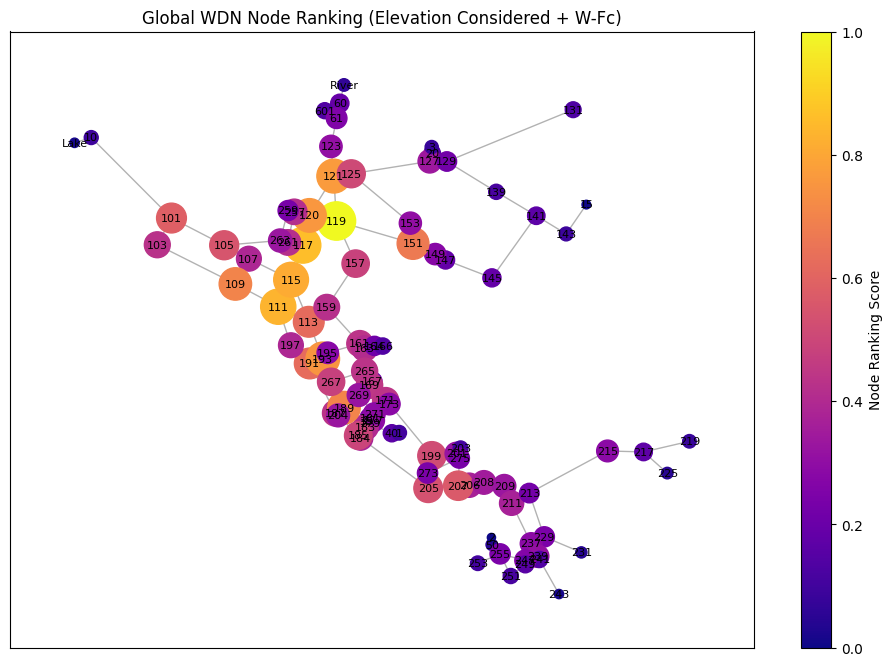

In [ ]:

!pip install wntr networkx pandas scikit-learn matplotlib


import wntr
import networkx as nx
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt


print("Please upload your EPANET (.inp) file:")
uploaded = files.upload()
inp_file_path = list(uploaded.keys())[0]


wn = wntr.network.WaterNetworkModel(inp_file_path)
G = wn.get_graph()
G = nx.Graph(G)


node_coordinates = {node_name: (node.coordinates[0], node.coordinates[1])
                    for node_name, node in wn.nodes() if node.coordinates}
elevation_data = {node_name: node.elevation for node_name, node in wn.junctions()}
demand_data = {node_name: node.base_demand for node_name, node in wn.junctions()}


elevation_data = {node: elevation_data.get(node, 0) for node in G.nodes()}
demand_data = {node: demand_data.get(node, 0) for node in G.nodes()}



wfc_values = {}
for node in resistance_graph.nodes():
    lengths = nx.single_source_dijkstra_path_length(resistance_graph, node, weight='weight')
    if len(lengths) > 1:
        wfc_values[node] = 1 / (sum(lengths.values()) / (len(lengths) - 1))
    else:
        wfc_values[node] = 0

for node in G.nodes():
    if node not in wfc_values:
        wfc_values[node] = 0




degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
shortest_path_length = {
    node: sum(nx.shortest_path_length(G, source=node).values()) / (len(G.nodes()) - 1)
    for node in G.nodes()
}


total_demand = sum(demand_data.values())
x_center = sum(node_coordinates[node][0] * demand_data[node] for node in G.nodes()) / total_demand
y_center = sum(node_coordinates[node][1] * demand_data[node] for node in G.nodes()) / total_demand
proximity_to_demand_center = {
    node: np.sqrt((node_coordinates[node][0] - x_center) ** 2 + (node_coordinates[node][1] - y_center) ** 2)
    for node in G.nodes()
}


metrics_df = pd.DataFrame({
    "Node": list(G.nodes()),
    "Elevation": [elevation_data[node] for node in G.nodes()],
    "Demand": [demand_data[node] for node in G.nodes()],
    "Proximity to Demand Center": [proximity_to_demand_center[node] for node in G.nodes()],
    "Degree Centrality": [degree_centrality[node] for node in G.nodes()],
    "Closeness Centrality": [closeness_centrality[node] for node in G.nodes()],
    "Betweenness Centrality": [betweenness_centrality[node] for node in G.nodes()],
    "Eigenvector Centrality": [eigenvector_centrality[node] for node in G.nodes()],
    "Shortest Path Length": [shortest_path_length[node] for node in G.nodes()],
    "Water Flow Closeness": [wfc_values[node] for node in G.nodes()]
})


scaler = MinMaxScaler()
normalized_metrics = pd.DataFrame(
    scaler.fit_transform(metrics_df.iloc[:, 1:]),
    columns=metrics_df.columns[1:]
)
normalized_metrics["Node"] = metrics_df["Node"]


normalized_metrics["Shortest Path Length"] = 1 - normalized_metrics["Shortest Path Length"]
normalized_metrics["Proximity to Demand Center"] = 1 - normalized_metrics["Proximity to Demand Center"]


normalized_metrics["Elevation"] = 1 - normalized_metrics["Elevation"]


probabilities = normalized_metrics.iloc[:, :-1].div(
    normalized_metrics.iloc[:, :-1].sum(axis=0), axis=1
)


probabilities = probabilities.replace(0, 1e-12)


k = 1 / np.log(len(probabilities))
entropy = -k * (probabilities * np.log(probabilities)).sum(axis=0)


divergence = 1 - entropy
weights = divergence / divergence.sum()


print("\n📊 Entropy-Based Weights for Each Metric:")
print(weights.round(4).sort_values(ascending=False))


weighted_metrics = normalized_metrics.iloc[:, :-1].mul(weights, axis=1)


normalized_metrics["Score"] = weighted_metrics.sum(axis=1)


normalized_metrics["Rank"] = normalized_metrics["Score"].rank(ascending=False)


normalized_metrics.to_csv("global_entropy_weighted_graph_metrics.csv", index=False)
print("Results saved to global_entropy_weighted_graph_metrics.csv")


files.download("global_entropy_weighted_graph_metrics.csv")


fig, ax = plt.subplots(figsize=(12, 8))


node_colors = normalized_metrics["Score"].values
node_sizes = normalized_metrics["Score"].values * 1000


nx.draw_networkx_nodes(
    G, pos=node_coordinates,
    nodelist=normalized_metrics["Node"].values,
    node_size=node_sizes,
    cmap=plt.cm.plasma,
    node_color=node_colors,
    ax=ax
)
nx.draw_networkx_edges(G, pos=node_coordinates, alpha=0.3, ax=ax)
nx.draw_networkx_labels(G, pos=node_coordinates, font_size=8, ax=ax)


plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.plasma), label="Node Ranking Score", ax=ax)
plt.title("Global WDN Node Ranking (Elevation Considered + W-Fc)")
plt.show()


In [ ]:
!pip install wntr==1.3.2 numpy==1.26.4

Please upload your EPANET (.inp) file:


Saving Net3_D0_F.inp to Net3_D0_F (2).inp

📊 Entropy-Based Weights for DMA: DMA1
Demand                        0.2617
Betweenness Centrality        0.2413
Degree Centrality             0.1385
Eigenvector Centrality        0.1383
Shortest Path Length          0.0863
Water Flow Closeness          0.0512
Proximity to Demand Center    0.0377
Closeness Centrality          0.0311
Elevation                     0.0139
dtype: float64

📊 Entropy-Based Weights for DMA: DMA2
Demand                        0.4198
Betweenness Centrality        0.1603
Degree Centrality             0.1057
Eigenvector Centrality        0.0840
Water Flow Closeness          0.0838
Closeness Centrality          0.0554
Proximity to Demand Center    0.0431
Shortest Path Length          0.0341
Elevation                     0.0138
dtype: float64

📊 Entropy-Based Weights for DMA: DMA3
Demand                        0.2236
Betweenness Centrality        0.1900
Eigenvector Centrality        0.1822
Degree Centrality             0.11

<ipython-input-3-f97e93e9b63e>:20: DeprecationWarning: wntr.network.WaterNetworkModel.get_graph is deprecated, use wntr.network.WaterNetworkModel.to_graph instead
  G = wn.get_graph()
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

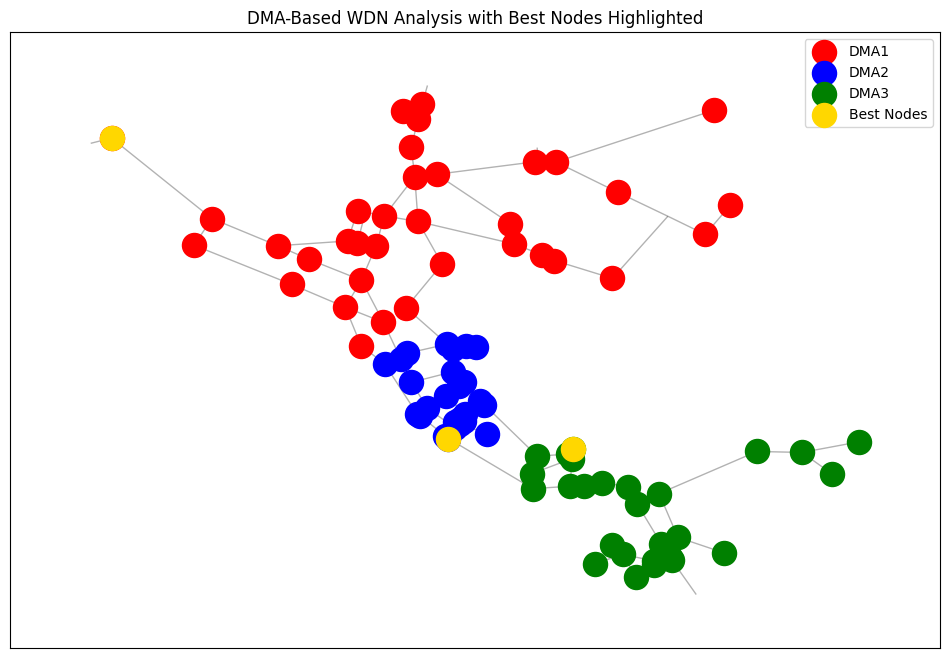

In [ ]:

!pip install wntr networkx pandas scikit-learn matplotlib


import wntr
import networkx as nx
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt


print("Please upload your EPANET (.inp) file:")
uploaded = files.upload()
inp_file_path = list(uploaded.keys())[0]


wn = wntr.network.WaterNetworkModel(inp_file_path)
G = wn.get_graph()
G = nx.Graph(G)

dma_nodes = {
    "DMA1": {10, 101, 197, 113, 159, 157, 119, 151, 149, 147, 145, 143, 15, 139, 129, 131,
             127, 125, 153, 121, 123, 61, 601, 60, 120, 259, 117, 261, 263, 105, 107, 115,
             111, 109, 103},
    "DMA2": {191, 193, 195, 161, 163, 164, 166, 265, 267, 169, 167, 269, 189, 187, 204,
             185, 183, 179, 35, 177, 181, 271, 171, 173, 184, 40},
    "DMA3": {199, 201, 203, 275, 273, 205, 207, 206, 208, 209, 211, 213, 215, 217, 219,
             225, 229, 231, 237, 239, 241, 249, 247, 255, 50, 253, 251, 273, 231}
}
dma_nodes = {k: {str(node) for node in v} for k, v in dma_nodes.items()}


node_coordinates = {node_name: (node.coordinates[0], node.coordinates[1])
                    for node_name, node in wn.nodes() if node.coordinates}
elevation_data = {node_name: node.elevation for node_name, node in wn.junctions()}
demand_data = {node_name: node.base_demand for node_name, node in wn.junctions()}
elevation_data = {node: elevation_data.get(node, 0) for node in G.nodes()}
demand_data = {node: demand_data.get(node, 0) for node in G.nodes()}


headloss_model = wn.options.hydraulic.headloss
resistance_graph = nx.Graph()
for pipe_name in wn.pipe_name_list:
    pipe = wn.get_link(pipe_name)
    n1, n2 = pipe.start_node_name, pipe.end_node_name
    if headloss_model == 'H-W':
        r = 4.727 * pipe.length / (pipe.roughness ** 1.852 * pipe.diameter ** 4.871)
    elif headloss_model == 'D-W':
        g = 9.81
        r = 8 * pipe.roughness * pipe.length / (np.pi**2 * g * pipe.diameter ** 5)
    else:
        raise ValueError("Unsupported headloss model.")
    resistance_graph.add_edge(n1, n2, weight=r)


final_results = []
best_nodes = {}

for dma, dma_nodes_list in dma_nodes.items():
    dma_nodes_filtered = [node for node in dma_nodes_list if node in G.nodes()]
    if not dma_nodes_filtered:
        print(f"Warning: DMA {dma} has no nodes in the graph. Skipping...")
        continue

    subgraph = G.subgraph(dma_nodes_filtered)
    degree_centrality = nx.degree_centrality(subgraph)
    closeness_centrality = nx.closeness_centrality(subgraph)
    betweenness_centrality = nx.betweenness_centrality(subgraph)
    eigenvector_centrality = nx.eigenvector_centrality(subgraph, max_iter=1000)
    shortest_path_length = {
        node: sum(nx.shortest_path_length(subgraph, source=node).values()) / (len(subgraph.nodes()) - 1)
        for node in subgraph.nodes()
    }

    total_demand = sum(demand_data[node] for node in dma_nodes_filtered)
    x_center = sum(node_coordinates[node][0] * demand_data[node] for node in dma_nodes_filtered) / total_demand
    y_center = sum(node_coordinates[node][1] * demand_data[node] for node in dma_nodes_filtered) / total_demand
    proximity_to_demand_center = {
        node: np.sqrt((node_coordinates[node][0] - x_center) ** 2 + (node_coordinates[node][1] - y_center) ** 2)
        for node in dma_nodes_filtered
    }

    wfc_values = {}
    for node in dma_nodes_filtered:
        if node in resistance_graph.nodes():
            lengths = nx.single_source_dijkstra_path_length(resistance_graph.subgraph(dma_nodes_filtered), node, weight='weight')
            if len(lengths) > 1:
                wfc_values[node] = 1 / (sum(lengths.values()) / (len(lengths) - 1))
            else:
                wfc_values[node] = 0
        else:
            wfc_values[node] = 0

    metrics_df = pd.DataFrame({
        "Node": dma_nodes_filtered,
        "Elevation": [elevation_data[node] for node in dma_nodes_filtered],
        "Demand": [demand_data[node] for node in dma_nodes_filtered],
        "Proximity to Demand Center": [proximity_to_demand_center[node] for node in dma_nodes_filtered],
        "Degree Centrality": [degree_centrality[node] for node in dma_nodes_filtered],
        "Closeness Centrality": [closeness_centrality[node] for node in dma_nodes_filtered],
        "Betweenness Centrality": [betweenness_centrality[node] for node in dma_nodes_filtered],
        "Eigenvector Centrality": [eigenvector_centrality[node] for node in dma_nodes_filtered],
        "Shortest Path Length": [shortest_path_length[node] for node in dma_nodes_filtered],
        "Water Flow Closeness": [wfc_values[node] for node in dma_nodes_filtered]
    })

    scaler = MinMaxScaler()
    normalized_metrics = pd.DataFrame(
        scaler.fit_transform(metrics_df.iloc[:, 1:]), columns=metrics_df.columns[1:]
    )
    normalized_metrics["Node"] = metrics_df["Node"]

    normalized_metrics["Shortest Path Length"] = 1 - normalized_metrics["Shortest Path Length"]
    normalized_metrics["Proximity to Demand Center"] = 1 - normalized_metrics["Proximity to Demand Center"]
    normalized_metrics["Elevation"] = 1 - normalized_metrics["Elevation"]

    probabilities = normalized_metrics.iloc[:, :-1].div(normalized_metrics.iloc[:, :-1].sum(axis=0), axis=1)
    probabilities = probabilities.replace(0, 1e-12)
    entropy = -1 / np.log(len(probabilities)) * (probabilities * np.log(probabilities)).sum(axis=0)
    weights = (1 - entropy) / (1 - entropy).sum()

    print(f"\n📊 Entropy-Based Weights for DMA: {dma}")
    print(weights.round(4).sort_values(ascending=False))

    weighted_metrics = normalized_metrics.iloc[:, :-1].mul(weights, axis=1)
    normalized_metrics["Score"] = weighted_metrics.sum(axis=1)
    normalized_metrics["Rank"] = normalized_metrics["Score"].rank(ascending=False)
    normalized_metrics["DMA"] = dma

    best_node = normalized_metrics.loc[normalized_metrics["Rank"].idxmax(), "Node"]
    best_nodes[dma] = best_node
    final_results.append(normalized_metrics)


final_output = pd.concat(final_results)


final_output.to_csv("dma_ranked_nodes.csv", index=False)
print("Results saved to dma_ranked_nodes.csv")


files.download("dma_ranked_nodes.csv")


plt.figure(figsize=(12, 8))
colors = ["red", "blue", "green"]
for i, (dma, dma_nodes_list) in enumerate(dma_nodes.items()):
    nx.draw_networkx_nodes(G, pos=node_coordinates, nodelist=list(dma_nodes_list),
                           node_color=colors[i], label=f"{dma}")

nx.draw_networkx_nodes(G, pos=node_coordinates, nodelist=list(best_nodes.values()),
                       node_color="gold", node_size=300, label="Best Nodes")
nx.draw_networkx_edges(G, pos=node_coordinates, alpha=0.3)
plt.legend()
plt.title("DMA-Based WDN Analysis with Best Nodes Highlighted")
plt.show()

Please upload your EPANET (.inp) file:


Saving Net3_D0_F.inp to Net3_D0_F (3).inp

📊 Entropy-Based Weights for Cluster 0:
Demand                        0.4193
Eigenvector Centrality        0.1532
Betweenness Centrality        0.1476
Degree Centrality             0.1068
Closeness Centrality          0.0532
Proximity to Demand Center    0.0416
Water Flow Closeness          0.0336
Shortest Path Length          0.0279
Elevation                     0.0168
dtype: float64


<ipython-input-4-706fbb49adab>:22: DeprecationWarning: wntr.network.WaterNetworkModel.get_graph is deprecated, use wntr.network.WaterNetworkModel.to_graph instead
  G = wn.get_graph()



📊 Entropy-Based Weights for Cluster 1:
Demand                        0.3708
Betweenness Centrality        0.1747
Eigenvector Centrality        0.1619
Degree Centrality             0.0957
Closeness Centrality          0.0624
Water Flow Closeness          0.0460
Shortest Path Length          0.0376
Proximity to Demand Center    0.0338
Elevation                     0.0171
dtype: float64

📊 Entropy-Based Weights for Cluster 2:
Demand                        0.2095
Betweenness Centrality        0.1968
Degree Centrality             0.1703
Eigenvector Centrality        0.1273
Closeness Centrality          0.0956
Water Flow Closeness          0.0768
Shortest Path Length          0.0704
Proximity to Demand Center    0.0334
Elevation                     0.0198
dtype: float64
Results saved to clustered_entropy_weighted_graph_metrics.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

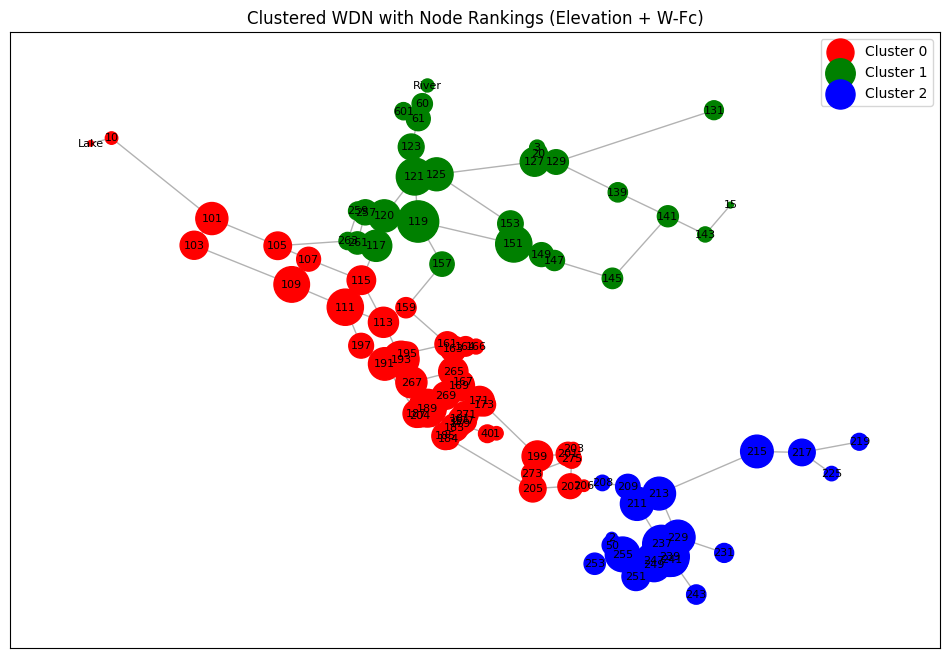

In [ ]:

!pip install wntr networkx pandas scikit-learn matplotlib


import wntr
import networkx as nx
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import SpectralClustering
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


print("Please upload your EPANET (.inp) file:")
uploaded = files.upload()
inp_file_path = list(uploaded.keys())[0]


wn = wntr.network.WaterNetworkModel(inp_file_path)
G = wn.get_graph()
G = nx.Graph(G)


node_coordinates = {node_name: (node.coordinates[0], node.coordinates[1])
                    for node_name, node in wn.nodes() if node.coordinates}
elevation_data = {node_name: node.elevation for node_name, node in wn.junctions()}
demand_data = {node_name: node.base_demand for node_name, node in wn.junctions()}
elevation_data = {node: elevation_data.get(node, 0) for node in G.nodes()}
demand_data = {node: demand_data.get(node, 0) for node in G.nodes()}


headloss_model = wn.options.hydraulic.headloss
resistance_graph = nx.Graph()
for pipe_name in wn.pipe_name_list:
    pipe = wn.get_link(pipe_name)
    n1, n2 = pipe.start_node_name, pipe.end_node_name
    if headloss_model == 'H-W':
        r = 4.727 * pipe.length / (pipe.roughness ** 1.852 * pipe.diameter ** 4.871)
    elif headloss_model == 'D-W':
        g = 9.81
        r = 8 * pipe.roughness * pipe.length / (np.pi**2 * g * pipe.diameter ** 5)
    else:
        raise ValueError("Unsupported headloss model.")
    resistance_graph.add_edge(n1, n2, weight=r)


adj_matrix = nx.adjacency_matrix(G, weight='weight').todense()


n_clusters = 3
clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
cluster_labels = clustering.fit_predict(adj_matrix)


for node, cluster in zip(G.nodes(), cluster_labels):
    G.nodes[node]['cluster'] = cluster


final_results = []


for cluster_id in range(n_clusters):
    cluster_nodes = [node for node in G.nodes() if G.nodes[node]['cluster'] == cluster_id]
    subgraph = G.subgraph(cluster_nodes)

    degree_centrality = nx.degree_centrality(subgraph)
    closeness_centrality = nx.closeness_centrality(subgraph)
    betweenness_centrality = nx.betweenness_centrality(subgraph)
    eigenvector_centrality = nx.eigenvector_centrality(subgraph, max_iter=1000)
    shortest_path_length = {
        node: sum(nx.shortest_path_length(subgraph, source=node).values()) / (len(subgraph.nodes()) - 1)
        for node in subgraph.nodes()
    }

    total_demand = sum(demand_data[node] for node in cluster_nodes)
    x_center = sum(node_coordinates[node][0] * demand_data[node] for node in cluster_nodes) / total_demand
    y_center = sum(node_coordinates[node][1] * demand_data[node] for node in cluster_nodes) / total_demand
    proximity_to_demand_center = {
        node: np.sqrt((node_coordinates[node][0] - x_center) ** 2 + (node_coordinates[node][1] - y_center) ** 2)
        for node in cluster_nodes
    }

    wfc_values = {}
    for node in cluster_nodes:
        if node in resistance_graph.nodes():
            lengths = nx.single_source_dijkstra_path_length(resistance_graph.subgraph(cluster_nodes), node, weight='weight')
            if len(lengths) > 1:
                wfc_values[node] = 1 / (sum(lengths.values()) / (len(lengths) - 1))
            else:
                wfc_values[node] = 0
        else:
            wfc_values[node] = 0

    metrics_df = pd.DataFrame({
        "Node": cluster_nodes,
        "Elevation": [elevation_data[node] for node in cluster_nodes],
        "Demand": [demand_data[node] for node in cluster_nodes],
        "Proximity to Demand Center": [proximity_to_demand_center[node] for node in cluster_nodes],
        "Degree Centrality": [degree_centrality[node] for node in cluster_nodes],
        "Closeness Centrality": [closeness_centrality[node] for node in cluster_nodes],
        "Betweenness Centrality": [betweenness_centrality[node] for node in cluster_nodes],
        "Eigenvector Centrality": [eigenvector_centrality[node] for node in cluster_nodes],
        "Shortest Path Length": [shortest_path_length[node] for node in cluster_nodes],
        "Water Flow Closeness": [wfc_values[node] for node in cluster_nodes]
    })

    scaler = MinMaxScaler()
    normalized_metrics = pd.DataFrame(
        scaler.fit_transform(metrics_df.iloc[:, 1:]), columns=metrics_df.columns[1:]
    )
    normalized_metrics["Node"] = metrics_df["Node"]

    normalized_metrics["Shortest Path Length"] = 1 - normalized_metrics["Shortest Path Length"]
    normalized_metrics["Proximity to Demand Center"] = 1 - normalized_metrics["Proximity to Demand Center"]
    normalized_metrics["Elevation"] = 1 - normalized_metrics["Elevation"]

    probabilities = normalized_metrics.iloc[:, :-1].div(normalized_metrics.iloc[:, :-1].sum(axis=0), axis=1)
    probabilities = probabilities.replace(0, 1e-12)
    entropy = -1 / np.log(len(probabilities)) * (probabilities * np.log(probabilities)).sum(axis=0)
    weights = (1 - entropy) / (1 - entropy).sum()

    print(f"\n📊 Entropy-Based Weights for Cluster {cluster_id}:")
    print(weights.round(4).sort_values(ascending=False))

    weighted_metrics = normalized_metrics.iloc[:, :-1].mul(weights, axis=1)
    normalized_metrics["Score"] = weighted_metrics.sum(axis=1)
    normalized_metrics["Rank"] = normalized_metrics["Score"].rank(ascending=False)
    normalized_metrics["Cluster"] = cluster_id
    final_results.append(normalized_metrics)


final_output = pd.concat(final_results)


final_output.to_csv("clustered_entropy_weighted_graph_metrics.csv", index=False)
print("Results saved to clustered_entropy_weighted_graph_metrics.csv")


files.download("clustered_entropy_weighted_graph_metrics.csv")


plt.figure(figsize=(12, 8))
cluster_colors = ['red', 'green', 'blue']
cmap = ListedColormap(cluster_colors[:n_clusters])

for cluster_id in range(n_clusters):
    cluster_nodes = final_output[final_output["Cluster"] == cluster_id]
    nx.draw_networkx_nodes(
        G, pos=node_coordinates,
        nodelist=cluster_nodes["Node"].values,
        node_size=cluster_nodes["Score"].values * 1000,
        node_color=cluster_colors[cluster_id],
        label=f"Cluster {cluster_id}"
    )

nx.draw_networkx_edges(G, pos=node_coordinates, alpha=0.3)
nx.draw_networkx_labels(G, pos=node_coordinates, font_size=8)
plt.legend()
plt.title("Clustered WDN with Node Rankings (Elevation + W-Fc)")
plt.show()

Please upload your EPANET (.inp) file:


Saving Net3_D0_F.inp to Net3_D0_F (1).inp


<ipython-input-2-026708072e0f>:33: DeprecationWarning: wntr.network.WaterNetworkModel.get_graph is deprecated, use wntr.network.WaterNetworkModel.to_graph instead
  G = nx.Graph(wn.get_graph())


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-2-026708072e0f>:138: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(zones))


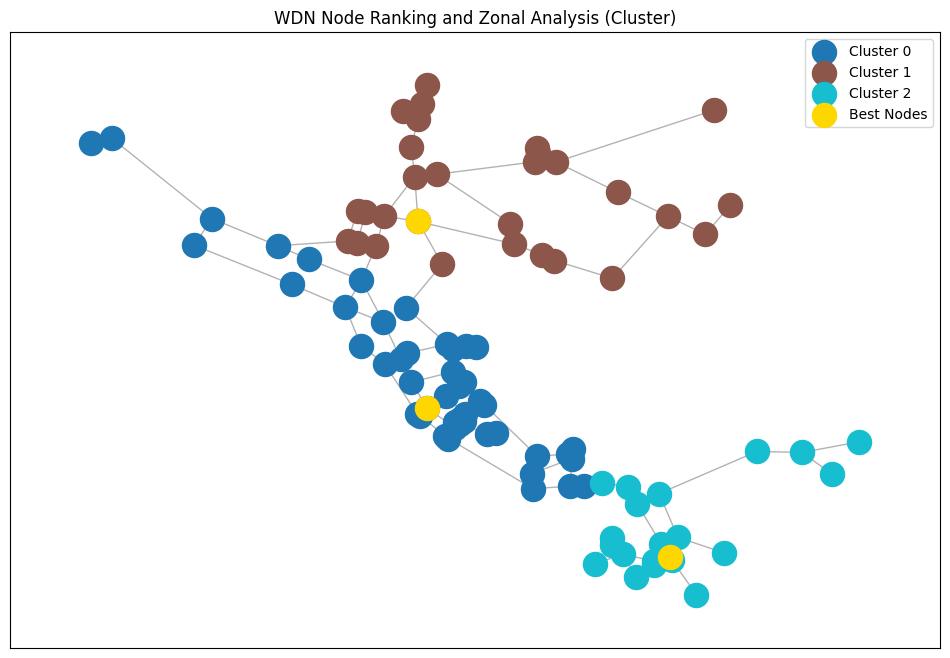

In [ ]:
import wntr
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from google.colab import files


print("Please upload your EPANET (.inp) file:")
uploaded = files.upload()
inp_file_path = list(uploaded.keys())[0]


config_type = 'cluster'
n_clusters = 3


dma_nodes = {
    "DMA1": {10, 101, 197, 113, 159, 157, 119, 151, 149, 147, 145, 143, 15, 139, 129, 131,
             127, 125, 153, 121, 123, 61, 601, 60, 120, 259, 117, 261, 263, 105, 107, 115,
             111, 109, 103},
    "DMA2": {191, 193, 195, 161, 163, 164, 166, 265, 267, 169, 167, 269, 189, 187, 204,
             185, 183, 179, 35, 177, 181, 271, 171, 173, 184, 40},
    "DMA3": {199, 201, 203, 275, 273, 205, 207, 206, 208, 209, 211, 213, 215, 217, 219,
             225, 229, 231, 237, 239, 241, 249, 247, 255, 50, 253, 251, 273, 231}
}


wn = wntr.network.WaterNetworkModel(inp_file_path)
G = nx.Graph(wn.get_graph())


elevation_data = {n: wn.get_node(n).elevation if hasattr(wn.get_node(n), 'elevation') else 0 for n in G.nodes()}
demand_data = {n: wn.get_node(n).base_demand if hasattr(wn.get_node(n), 'base_demand') else 0 for n in G.nodes()}
node_coordinates = {n: wn.get_node(n).coordinates for n in G.nodes() if wn.get_node(n).coordinates}


headloss_model = wn.options.hydraulic.headloss
resistance_graph = nx.Graph()

resistance_graph.add_nodes_from(G.nodes())
for pipe_name in wn.pipe_name_list:
    pipe = wn.get_link(pipe_name)
    n1, n2 = pipe.start_node_name, pipe.end_node_name
    if headloss_model == 'H-W':
        r = 4.727 * pipe.length / (pipe.roughness ** 1.852 * pipe.diameter ** 4.871)
    elif headloss_model == 'D-W':
        g = 9.81
        r = 8 * pipe.roughness * pipe.length / (np.pi**2 * g * pipe.diameter ** 5)
    resistance_graph.add_edge(n1, n2, weight=r)


if config_type == 'global':
    zones = {"Global": list(G.nodes())}

elif config_type == 'dma':
    zones = {dma: [n for n in nodes if n in G.nodes()] for dma, nodes in dma_nodes.items()}

elif config_type == 'cluster':
    adj_matrix = nx.adjacency_matrix(G).todense()
    clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels = clustering.fit_predict(adj_matrix)
    zones = {f"Cluster {i}": [] for i in range(n_clusters)}
    for node, label in zip(G.nodes(), labels):
        zones[f"Cluster {label}"].append(node)


final_results = []
best_nodes = {}
for zone_name, nodes in zones.items():
    subgraph = G.subgraph(nodes)

    degree = nx.degree_centrality(subgraph)
    closeness = nx.closeness_centrality(subgraph)
    betweenness = nx.betweenness_centrality(subgraph)
    eigenvector = nx.eigenvector_centrality(subgraph, max_iter=1000)
    shortest = {n: sum(nx.shortest_path_length(subgraph, source=n).values()) / (len(subgraph)-1) for n in subgraph}

    total_demand = sum(demand_data[n] for n in nodes)
    x_center = sum(node_coordinates[n][0] * demand_data[n] for n in nodes if n in node_coordinates) / total_demand
    y_center = sum(node_coordinates[n][1] * demand_data[n] for n in nodes if n in node_coordinates) / total_demand
    proximity = {n: np.sqrt((node_coordinates[n][0] - x_center)**2 + (node_coordinates[n][1] - y_center)**2) if n in node_coordinates else 0 for n in nodes}

    wfc = {}
    for n in nodes:

        if n in resistance_graph.nodes():
            lengths = nx.single_source_dijkstra_path_length(resistance_graph.subgraph(nodes), n, weight='weight')
            wfc[n] = 1 / (sum(lengths.values()) / (len(lengths)-1)) if len(lengths) > 1 else 0
        else:
            wfc[n] = 0

    df = pd.DataFrame({
        "Node": nodes,
        "Elevation": [elevation_data[n] for n in nodes],
        "Demand": [demand_data[n] for n in nodes],
        "Proximity": [proximity[n] for n in nodes],
        "Degree": [degree[n] for n in nodes],
        "Closeness": [closeness[n] for n in nodes],
        "Betweenness": [betweenness[n] for n in nodes],
        "Eigenvector": [eigenvector[n] for n in nodes],
        "ShortestPath": [shortest[n] for n in nodes],
        "W-Fc": [wfc[n] for n in nodes]
    })

    scaler = MinMaxScaler()
    norm = pd.DataFrame(scaler.fit_transform(df.iloc[:, 1:]), columns=df.columns[1:])
    norm['Node'] = df['Node']

    for col in ['ShortestPath', 'Proximity', 'Elevation']:
        norm[col] = 1 - norm[col]

    probs = norm.drop(columns='Node').div(norm.drop(columns='Node').sum(axis=0), axis=1).replace(0, 1e-12)
    k = 1 / np.log(len(probs))
    entropy = -k * (probs * np.log(probs)).sum()
    weights = (1 - entropy) / (1 - entropy).sum()

    scores = norm.drop(columns='Node').mul(weights, axis=1).sum(axis=1)
    norm['Score'] = scores
    norm['Rank'] = scores.rank(ascending=False)
    norm['Zone'] = zone_name

    top_node = norm.loc[norm['Score'].idxmax(), 'Node']
    best_nodes[zone_name] = top_node
    final_results.append(norm)


final_df = pd.concat(final_results)
filename = f"combined_entropy_ranking_{config_type}.csv"
final_df.to_csv(filename, index=False)
files.download(filename)


plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap('tab10', len(zones))
for i, (zone_name, zone_nodes) in enumerate(zones.items()):
    nx.draw_networkx_nodes(G, pos=node_coordinates, nodelist=zone_nodes, node_color=[colors(i)], label=zone_name)
nx.draw_networkx_nodes(G, pos=node_coordinates, nodelist=list(best_nodes.values()), node_color='gold', node_size=300, label='Best Nodes')
nx.draw_networkx_edges(G, pos=node_coordinates, alpha=0.3)
plt.legend()
plt.title(f"WDN Node Ranking and Zonal Analysis ({config_type.capitalize()})")
plt.show()